## Part 1: Get the wine dataset

The wine dataset is data gathered from a chemical analysis of wines to determine their origin. It has 13 features and three different types of labels (1, 2, 3). 59 examples are in class 1, 71 examples in class 2, and 48 in class 3 for a total of 178 examples.

In [3]:
# Split data into training and test set
import numpy as np
import pandas as pd

df = pd.read_csv('wine\wine.csv')
print("Total rows: ", len(df))
# print(df)

# wine = np.array(df)
# print(wine)

train_idxs = np.random.choice(range(len(df)), size=int(0.8*len(df)))
print(train_idxs)
train = df.iloc[train_idxs]
print("Training set rows: ",len(train))

test_idxs = np.full(len(df), True)
test_idxs[train_idxs] = False
test = df.iloc[test_idxs]
print("Test set rows: ",len(test))

train.to_csv('wine-train.csv')
test.to_csv('wine-test.csv')


Total rows:  177
[ 14 131  16 162 106  96 156 170  98 143  58 114 109 171  70  88  30 118
  93 114  21  27  40  91 155  77   5  31  40  91  22 124  54  80 102  81
 150 172 167  37  27  44   7  92  17 143 105  11  71  32 172  49  59  45
  20 160  31 139  26  13  20  10 109 118  61 123  98  28 133  42 160  35
  76 136 104 167 161 153 105 112  54  27  49  82 149  63  49  83 115  50
  93  45 157  11 137 114 129  60  48 174 143 122  25 103  42 104 105  28
 128 161  58  75  99  96  10   7  36  30 165 174 126  26  61  99  21  78
  60  74 110 170 102  17  82 164  43 167 127  63 140 149  82]
Training set rows:  141
Test set rows:  83


In [5]:
# Split training data into training and cross validation sets
from sklearn.model_selection import train_test_split
from collections import Counter

df_train = pd.read_csv('wine-train.csv')
train = np.array(df_train, dtype=float)

train, valid = train_test_split(train, shuffle=True)

# Split test and validation data into X and Y (inputs and labels)
train_y, train_X, valid_y, valid_X = train[:, 1], train[:, 2 : ], valid[:, 1], valid[:, 2 : ] # The labels are in column number 2, the Xs are column 3 onwards

# Split test data into X and Y (inputs and labels)
test = np.array(pd.read_csv('wine-test.csv'))
test_y, test_X = test[:, 1], test[:, 2 : ]
test_y = np.array(test_y, int)
# Look at the balance of classes to make sure that evaluating models on just their accuracy is okay
print(Counter(test_y))
print(Counter(train_y))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]
Counter({2: 31, 1: 28, 3: 24})
Counter({2.0: 42, 1.0: 35, 3.0: 28})


## Part 2: Fit models to the wine dataset and test performance

Using a classification tree on the model. Evaluate the model's performance by comparing its predicted labels with the test labels using accuracy (the fraction of the predictions that were correct).


In [12]:
# run a classification tree on the dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier()
tree.fit(test_X, test_y)

# Evaluate performance on cross validation set
pred_y = tree.predict(valid_X)
print(accuracy_score(valid_y, pred_y))

# Evaluate performance by comparing with test data
pred_y = tree.predict(test_X)
print(accuracy_score(test_y, pred_y))


0.8333333333333334
1.0


## Part 3: Ensembling to improve performance

Ensemble the classification tree model used above buy using random forests. Evaluate model by looking at its accuracy. 

In [13]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=100, max_depth=2, max_samples=10)
randomForest.fit(train_X, train_y) # fit random forest of decision trees

# Evaluate the ensemble's performance
score = randomForest.score(test_X, test_y) # use the model's score method to compute it's accuracy
print(score)



0.9397590361445783


## Part 4: Finding the best models and hyperparameters

We have used the following models for supervised learning classification problems so far: Logistic Regression, RandomForests, Support Vector Machines, and K nearest-neighbours. Using sklearn's VotingClassifier, we can ensemble different models and using sklearn's accuracy_score, we can compare the accuracies to find the best single model, or ensemble of models. 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from numpy import random
import itertools


def update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model):
    # A function to see if this current model gives a better accuracy than any previous models, and then to update the new best model
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    accuracy = accuracy_score(test_y, pred_y) # If this accuracy is highest so far, then update the best model with this model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    return best_accuracy, best_model

def parameter_search(model_name, train_X, train_y, test_X, test_y,  estimators=[], n_samples=100,):
            """
            Hyperparameter search function.

            Finds the best parameters of a given model based on whichever parameters give the highest accuracy score.
            Works with the following scikit-learn models: RandomForestClassifier, LogisticRegression, SVC and KNeighborsClassifier.

            Parameters 

            model_name:{"RandomForestClassifier", "LogisticRegression", "SVC", "KNeighborsClassifier"}
                Depending on the model chosen, different hyperparameters will be returned. 
                For "RandomForestClassifier", the n_estimators, max_depth and max_samples will be returned
                For "LogisticRegression", the C will be returned
                For "SVC", the C and gamma will be returned
                For "KNeighborsClassifier", the n_neighbours will be returned.

            train_X, train_y, test_X, test_y: numpy array
                This will take in the training data and test data in the order of the training Xs then ys, then the test Xs then ys.

            n_samples: int, default=1000
                How many samples of each hyperparameter are required, meaning a total of (n_samples**number of hyperparameters) samples will be taken.

            """
            # Initialise best accuracy and best model variables
            best_accuracy = 0
            best_model = None

            # Search for different parameteres depending on the model
            if model_name == "RandomForestClassifier":
                for i in range(1, min(len(train_X), n_samples) + 1): # There can't be more samples than there are examples in data
                    for j in range(1, 5): # Trees should remain short in random forests
                        model = RandomForestClassifier(max_samples=i,max_depth=j)
                        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name == "DecisionTreeClassifier":
                for i in range(1, n_samples+1): # Try all the max_depths until you reach n_samples
                    model = DecisionTreeClassifier(max_depth=i)
                    best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name in ["LogisticRegression","SVC"]:
                half = int(n_samples/2)
                C = random.exponential(scale=1, size=(half)) # let half of the values for C be small (roughly between 0 and 1)
                C = np.append(C, 10*random.exponential(scale=100, size=(n_samples-half))) # let other half be big (roughly between 10 and 10000)
                for c in C:
                    if model_name == "LogisticRegression":
                        model = LogisticRegression(C=c)
                        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
                    else:
                        for g in C:
                            model = SVC(C=c, gamma=g)
                            best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name == "KNeighborsClassifier":
                for i in range(1, min(len(train_X), n_samples) + 1): # There can't be more neighbours than there are examples in the data
                    # Initialise and test the model on these parameters
                    model = KNeighborsClassifier(n_neighbors=i)
                    best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name == "VotingClassifier":
                total_combs_of_estimators = []
                for i in range(2, len(estimators) + 1): # get all the different combinations of the models for ensembling
                    total_combs_of_estimators.extend(list(itertools.combinations(estimators, i)))
                for estimator in total_combs_of_estimators:
                    model = VotingClassifier(estimators=estimator, voting='hard')
                    best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            else:
                print("Please check the documentation and specify a relevant model")
                return
            # get the relevant key parameters from the best model
            print("The best parameters have been found for", best_model.__class__.__name__, "with an accuracy of", best_accuracy, "on the cross validation data, with key parameters:")
            list_of_key_params = ["max_samples", "max_depth", "C", "gamma", "n_neighbours", "estimators"]
            all_params = best_model.get_params()
            # print(all_params)
            for param in list_of_key_params:
                # print(param)
                if param in all_params:
                    print(param + " = " + str(all_params[param]))
            print()
            return best_model



def BestModelAndParameter(train_X, train_y, valid_X, valid_y, test_X, test_y, n_samples=100):
    
    # initialise every model with their best parameters, using VALIDATION data not test data
    
    ran_for = parameter_search("RandomForestClassifier",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    des_tree = parameter_search("DecisionTreeClassifier", train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    log_reg = parameter_search("LogisticRegression",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    sup_vec = parameter_search("SVC",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    K_near = parameter_search("KNeighborsClassifier",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    
    estimators = [('dt', des_tree), ('rf', ran_for), ('lr', log_reg), ('svc', sup_vec), ('Knear', K_near)]
    voting = parameter_search("VotingClassifier",train_X, train_y, valid_X, valid_y,estimators=estimators)

    best_accuracy = 0
    best_model = None
    for model in (des_tree, ran_for, log_reg, sup_vec, K_near, voting):
        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
        print("On the training data, model", model.__class__.__name__, "has an accuracy of:", accuracy_score(test_y, model.predict(test_X)))
    print("\nTherefore, the best model was", best_model.__class__.__name__, "with an accuracy of", best_accuracy)
    return best_model

model = BestModelAndParameter(train_X, train_y, valid_X, valid_y, test_X, test_y, 150)



The best parameters have been found for RandomForestClassifier with an accuracy of 1.0 on the cross validation data, with key parameters:
max_samples = 4
max_depth = 3

The best parameters have been found for DecisionTreeClassifier with an accuracy of 0.9722222222222222 on the cross validation data, with key parameters:
max_depth = 6

The best parameters have been found for LogisticRegression with an accuracy of 0.9722222222222222 on the cross validation data, with key parameters:
C = 2662.588080837724

The best parameters have been found for SVC with an accuracy of 0.6388888888888888 on the cross validation data, with key parameters:
C = 1.0294798372489824
gamma = 1.0294798372489824

The best parameters have been found for KNeighborsClassifier with an accuracy of 0.8333333333333334 on the cross validation data, with key parameters:

The best parameters have been found for VotingClassifier with an accuracy of 0.9722222222222222 on the cross validation data, with key parameters:
estima

## Part 5: Present your results

1. It is clear that using the aboth three functions we can have the optimal model returned, ready loaded with the optimal parameters. The results of this final model are shown on the graph below.

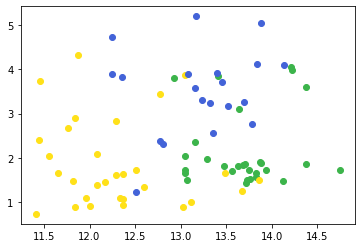

ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 2 

In [7]:
import sys
sys.path.append('..')
from utils import get_classification_data, show_data, visualise_predictions, colors

accuracy_score(model.predict(test_X), test_y)
show_data(test_X, test_y)
visualise_predictions(model.predict, test_X, test_y)

Part 5 (continued):

2. It seems that support vector machines consintently performs the worst, with K-nearest neighbours coming in second worst. Looking at their performance on the validation data however, it seems that K-nearest neighbours achieved an accuracy of near 90%, which means that this model was perhaps overfitting to the training data and failing to generalise to new examples. Support vector machines did poorly on the validation data and much worse on the test data. SVMs work best with data that has clearly defined margins of separation between groups, meaning that it might not have been clear with this data. This is best shown with the visualisation of the data above, and seeing that there are no distinct boundaries between the three classes. Logistic Regression and Random Forests seem to be performing the best on the data, sugessting that the data is more suited for them.

3. The best permutation found was Logistic Regression with an accuracy of 90.36% and a C parameter value of 2662.588080837724 using the L2 norm. Since larger values of C indicate weaker regularistion, a value this large suggests a very weak use of regularistion was the best. This model generalises very well, as the accuracy only dropped a little on the test data from the validation data, whereas other models like Random Forests had a perfect accuracy on the validation data but an ever larger drop in accuracy on test data. This suggests there is a good balance between variance and bias with this Logistic Regression model.

## Part 6: "A stakeholder asks you which features most affect the response variable (output). Describe how you would organise a test to determine this."

I would test this by manipulating the input data for the models, such that all the Xs for one feature are set to zero, and then repeating this until every feature has had a chance to be set to zero. I would then compare which result ends up with the biggest difference from the original result which had all features included. The feature when set to zero that correspends to the biggest difference in accuracy, would therefore be the feature that has the greatest influence over the response variable. 